# Government Subsidy Version
## 0 - Imports

In [120]:
import pandas as pd
import numpy as np
import os
import math
import pulp
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from scipy.spatial import KDTree
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value
from shapely.geometry import Point
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.optimize import minimize
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary, value
from shapely.geometry import LineString, Point, MultiLineString
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.optimize import minimize
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary
from shapely.geometry import LineString
# (Other plotting libraries like Basemap assumed installed if needed.)
pd.set_option('display.max_columns', None)

## 1 - Define Functions

In [57]:
#############################
# 1. UTILITY FUNCTIONS
#############################

def haversine(coord1, coord2):
    """
    Calculate the great-circle distance between two (lat, lon) coordinates.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    radius = 3958.8  # Earth radius in miles
    return radius * c

def round_coordinates(coord, precision=6):
    """
    Round coordinates to given precision.
    """
    return tuple(round(c, precision) for c in coord)

def get_segments_from_path(path):
    """
    Given a list of nodes (a rail path), return a set of segments (as sorted tuples) that make up that path.
    """
    segments = []
    for i in range(len(path)-1):
        seg = tuple(sorted((path[i], path[i+1])))
        segments.append(seg)
    return list(set(segments))

#############################
# 2. DATA IMPORT & CLEANING
#############################

def import_and_clean_flight_data():
    """
    Read flight data and airport locations.
    """
    path = os.path.expanduser("/Users/nicholasaronow/Desktop/THESIS/Data/Airline/Origin_and_Destination_Survey_DB1BMarket_2024_1/Origin_and_Destination_Survey_DB1BMarket_2024_1.csv")
    data = pd.read_csv(path)
    airports_path = os.path.expanduser("/Users/nicholasaronow/Desktop/THESIS/Data/Airline/airports.csv")
    airports = pd.read_csv(airports_path)
    return data, airports

def import_and_clean_rail_data():
    """
    Read rail data files and aggregate into DataFrames.
    """
    path1 = os.path.expanduser("/Users/nicholasaronow/Desktop/THESIS/Data/Rail/NTAD_North_American_Rail_Network_Lines_Passenger_Rail_2478919022486987594.csv")
    path3 = os.path.expanduser("/Users/nicholasaronow/Desktop/THESIS/Data/us_county_latlng.csv")
    
    data1 = pd.read_csv(path1)
    data3 = pd.read_csv(path3)
    
    df_merged = pd.merge(data1, data3, left_on='STCNTYFIPS', right_on='fips_code', how='left')

    tracks_data = []
    grouped = df_merged.groupby('BRANCH')
    for branch, group in grouped:
        group = group.sort_values(by='FRFRANODE')
        for i in range(len(group) - 1):
            from_node = group.iloc[i]
            to_node = group.iloc[i + 1]
            if from_node['TOFRANODE'] == to_node['FRFRANODE']:
                origin_lat, origin_lng = from_node['lat'], from_node['lng']
                dest_lat, dest_lng = to_node['lat'], to_node['lng']
                bird_eye_miles = haversine((origin_lat, origin_lng), (dest_lat, dest_lng))
                track_miles = from_node['KM'] / 1.6
                tracks_data.append({
                    'Origin Lat': origin_lat,
                    'Origin Lon': origin_lng,
                    'Dest Lat': dest_lat,
                    'Dest Lon': dest_lng,
                    'Track Miles': track_miles,
                    'Birds-Eye Miles': bird_eye_miles,
                    'Track ID': from_node['FRAARCID'],
                    'State': from_node['STATEAB']
                })
    tracks_df = pd.DataFrame(tracks_data)
    return tracks_df, df_merged

def import_and_clean_shapefiles():
    """
    Import and clean rail shapefiles.
    """
    shapefile_path = os.path.expanduser(
        "/Users/nicholasaronow/Desktop/THESIS/Data/Rail/NTAD_North_American_Rail_Network_Lines_Passenger_Rail_4265145425102636751/North_American_Rail_Network_Lines.shp"
    )
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.dropna(subset=["geometry"])
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    # Get start and endpoints
    def get_start_end_points(geom):
        if isinstance(geom, LineString):
            coords = list(geom.coords)
        elif isinstance(geom, MultiLineString):
            coords = []
            for part in geom:
                coords.extend(part.coords)
        else:
            return None, None
        return coords[0], coords[-1]
    gdf['startpoint'], gdf['endpoint'] = zip(*gdf['geometry'].apply(get_start_end_points))
    gdf = gdf.dropna(subset=["startpoint", "endpoint"])
    return gdf

def sample_flights(data, airports, n):
    """
    Sample and aggregate flight data.
    """
    sample_data = data.sample(n)
    flights_with_origin = pd.merge(
        sample_data, 
        airports, 
        how='left', 
        left_on='Origin', 
        right_on='IATA'
    ).rename(columns={'LATITUDE': 'origin_lat', 'LONGITUDE': 'origin_long'})
    
    flights_with_orig_dest = pd.merge(
        flights_with_origin, 
        airports, 
        how='left', 
        left_on='Dest', 
        right_on='IATA'
    ).rename(columns={'LATITUDE': 'dest_lat', 'LONGITUDE': 'dest_long'})
    
    flights_aggregated = flights_with_orig_dest.groupby(
        ['Origin', 'Dest', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'OriginState', 'DestState', 'MktFare']
    ).size().reset_index(name='flight_count')
    return flights_aggregated

def flights_markov(flights_aggregated):
    """
    Create a steady state probabilities dictionary using Markov chain methods.
    """
    flights_departing = flights_aggregated.groupby('Origin')['flight_count'].sum().reset_index()
    flights_departing = flights_departing.rename(columns={'flight_count': 'total_flights'})
    flights_with_probs = pd.merge(flights_aggregated, flights_departing, on='Origin')
    flights_with_probs['transition_prob'] = flights_with_probs['flight_count'] / flights_with_probs['total_flights']
    airports = pd.concat([flights_aggregated['Origin'], flights_aggregated['Dest']]).unique()
    airport_index = {airport: idx for idx, airport in enumerate(airports)}
    n_airports = len(airports)
    transition_matrix = np.zeros((n_airports, n_airports))
    for index, row in flights_with_probs.iterrows():
        origin_idx = airport_index[row['Origin']]
        dest_idx = airport_index[row['Dest']]
        transition_matrix[origin_idx, dest_idx] = row['transition_prob']
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    steady_state_index = np.argmin(np.abs(eigenvalues - 1))
    steady_state_vector = np.real(eigenvectors[:, steady_state_index])
    steady_state_vector = steady_state_vector / steady_state_vector.sum()
    steady_state_dict = {airport: steady_state_vector[i] for airport, i in airport_index.items()}
    return steady_state_dict

#############################
# 3. RAIL NETWORK & PATHS
#############################

def create_rail_graph(gdf):
    """
    Create an undirected graph representation of the rail network.
    """
    G = nx.Graph()
    for _, row in gdf.iterrows():
        start = tuple(round_coordinates(row["startpoint"]))
        end = tuple(round_coordinates(row["endpoint"]))
        # Use the provided MILES column (or compute distance if needed)
        distance = row["MILES"] if "MILES" in row else haversine(start, end)
        G.add_edge(start, end, weight=distance)
    return G

# Build the rail graph from shapefiles
gdf = import_and_clean_shapefiles()
rail_graph = create_rail_graph(gdf)
# Relabel nodes by rounding coordinates
rail_graph = nx.relabel_nodes(rail_graph, round_coordinates)
railway_nodes = list(rail_graph.nodes)
node_coords = np.array([list(node) for node in railway_nodes])
kdtree = KDTree(node_coords)

## 2 - Prepare Flight & Rail Data

In [122]:
#############################
# 2. PREPARE FLIGHT ROUTES & COMPUTE RAIL PATHS
#############################

# Constants and parameters
n = 10000  # number of flights to sample
cost_of_upgrading = 77_063_620   # cost per mile to upgrade
cost_of_operating = np.mean([90000, 102000])  # operating cost per mile
BUDGET = 100_000_000_000  # available capital budget
flight_speed = 600  # mph (flights)
hsr_speed = 200  # mph (high-speed rail)
rail_station_delay = 51.44  # additional minutes added to door-to-door rail trips
flight_delay = 2*51.44

# Import flight data
flight_data, airport_data = import_and_clean_flight_data()
flights_aggregated = sample_flights(flight_data, airport_data, n)
flights_aggregated = (
    flights_aggregated
    .groupby(['Origin', 'Dest', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'OriginState', 'DestState'], as_index=False)
    .agg({'MktFare': 'mean', 'flight_count': 'sum'})
)
ss_dict = flights_markov(flights_aggregated)

# Scale flight demand to reflect full demand (using a shrink factor)
shrink_factor = n / len(flight_data)
flights_aggregated["proxy_flight_demand"] = np.floor(flights_aggregated["flight_count"] / shrink_factor)
# Assume each flight generates multiple trips per year (e.g., 91 days * 12 trips per day * some factor)
flights_aggregated["proxy_trip_demand"] = np.floor(flights_aggregated["proxy_flight_demand"] * (1/0.22)) * 91 * 12

# Compute direct flight distance and flight time (including a fixed wait time, e.g., 45 minutes)
flights_aggregated["distance"] = flights_aggregated.apply(
    lambda row: haversine((row["origin_lat"], row["origin_long"]), (row["dest_lat"], row["dest_long"])), axis=1
)
#flights_aggregated["flight_time"] = flights_aggregated["distance"] / flight_speed * 60 + flight_delay
flights_aggregated["flight_time"] = flights_aggregated["distance"].apply(lambda d: d / 172 if d < 177 else (d - 177) / 600 * 60 + 61.74) + flight_delay
# For computational tractability, work with a subset (e.g., first 1000 aggregated OD pairs)
# For final cut, use all flights_aggregated
routes_df = flights_aggregated

Processed 100 rows ...
Processed 200 rows ...
Processed 300 rows ...
Processed 400 rows ...
Processed 500 rows ...
Processed 600 rows ...
Processed 700 rows ...
Processed 800 rows ...
Processed 900 rows ...
Processed 1000 rows ...
Processed 1100 rows ...
Processed 1200 rows ...
Processed 1300 rows ...
Processed 1400 rows ...
Processed 1500 rows ...
Processed 1600 rows ...
Processed 1700 rows ...
Processed 1800 rows ...
Processed 1900 rows ...
Processed 2000 rows ...
Processed 2100 rows ...
Processed 2200 rows ...
Processed 2300 rows ...
Processed 2400 rows ...
Processed 2500 rows ...
Processed 2600 rows ...
Processed 2700 rows ...
Processed 2800 rows ...
Processed 2900 rows ...
Processed 3000 rows ...
Processed 3100 rows ...
Processed 3200 rows ...
Processed 3300 rows ...
Processed 3400 rows ...
Processed 3500 rows ...
Processed 3600 rows ...
Processed 3700 rows ...
Processed 3800 rows ...
Processed 3900 rows ...
Processed 4000 rows ...
Processed 4100 rows ...
Processed 4200 rows ...
P

/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/2071409433.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df["segments"] = routes_df["path"].apply(get_segments_from_path)
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/2071409433.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df["upgraded_rail_time"] = routes_df["rail_distance"] / hsr_speed * 60
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/2071409433.py:108: SettingWithCopyWar

## 3 - Process Flight and Rail Data

In [ ]:
# For each route, compute the rail path between origin and destination using nearest nodes on the rail network.
def process_row(row):
    # Increase the counter
    process_row.counter += 1
    
    # Optional: print progress every N rows
    if process_row.counter % 100 == 0:
        print(f"Processed {process_row.counter} rows ...")

    point1 = round_coordinates((row["origin_long"], row["origin_lat"]))
    point2 = round_coordinates((row["dest_long"], row["dest_lat"]))
    k = 5
    distances1, indices1 = kdtree.query(point1, k=k)
    distances2, indices2 = kdtree.query(point2, k=k)
    start_node, end_node = None, None
    found = False

    for idx1 in np.atleast_1d(indices1):
        candidate_start = tuple(node_coords[idx1])
        for idx2 in np.atleast_1d(indices2):
            candidate_end = tuple(node_coords[idx2])
            if nx.has_path(rail_graph, candidate_start, candidate_end):
                start_node = candidate_start
                end_node = candidate_end
                found = True
                break
        if found:
            break

    if not found:
        return pd.Series([np.nan, np.nan, []])
    
    try:
        path = nx.shortest_path(rail_graph, source=start_node, target=end_node, weight="weight")
        rail_distance = nx.shortest_path_length(rail_graph, source=start_node, target=end_node, weight="weight")
        # Conventional rail time assumed at 50 mph
        rail_time = (rail_distance / 50.0) * 60
    except nx.NetworkXNoPath:
        return pd.Series([np.nan, np.nan, []])

    return pd.Series([rail_distance, rail_time, path])

# Initialize the counter attribute
process_row.counter = 0

# Now apply your function
routes_df[['rail_distance', 'rail_time', 'path']] = routes_df.apply(process_row, axis=1)

routes_df = routes_df.dropna(subset=["rail_distance"])

# Add the list of segments (edges) used by each route
routes_df["segments"] = routes_df["path"].apply(get_segments_from_path)

# For HSR, recompute travel time along the rail path using the high-speed rail speed.
routes_df["upgraded_rail_time"] = routes_df["rail_distance"] / hsr_speed * 60 + rail_station_delay
# Compute door-to-door time savings (flight time minus [upgraded rail time + station delay])
routes_df["time_savings"] = routes_df["upgraded_rail_time"]+ rail_station_delay - (routes_df["flight_time"])

## 4 - Price and Revenue Estimation

In [775]:
#############################
# 5. PRICE & REVENUE ESTIMATION
#############################

# Logit Demand Model parameters and functions (for HSR)
alpha = 5     # baseline preference
beta = 0.1    # price sensitivity
gamma = 0.02  # time sensitivity

def logit_demand(price_train, price_plane, base_demand, time_savings, alpha=0, beta=-0.05, gamma=0.05):
    """
    Models demand for train travel using a logit function based on price and time differences.
    
    Parameters:
    price_train (float): Ticket price for train travel.
    price_plane (float): Cost of plane travel (fuel, tolls, etc.).
    base_demand (float): Total potential demand in the market.
    time_train (float): Time required for train travel.
    time_plane (float): Time required for plane travel.
    alpha (float): Base utility constant.
    beta (float): Price sensitivity coefficient.
    gamma (float): Time sensitivity coefficient.
    
    Returns:
    float: Estimated demand for train travel.
    """
    price_diff = price_train - price_plane
    
    # Utility function for train travel
    utility = alpha + beta * price_diff + gamma * (-time_savings)
    
    # Compute the probability of choosing train travel
    train_share = np.exp(utility) / (1 + np.exp(utility))
    
    return train_share * base_demand

def profit_function(price, market_fare, total_demand, cost_per_passenger, time_savings):
    # For simplicity in this government-funded scenario, we set demand = total_demand
    demand = logit_demand(price, market_fare, total_demand, time_savings, alpha=0, beta=-0.05, gamma=0.05)  
    return -(price - cost_per_passenger) * demand

# Use a square-root model for construction time (reflecting plateauing project duration)
# These constants can be calibrated using regression (here we assume example values)
const_a = 0.01
const_b = 7.2
# Set max years at 10
routes_df["construction_time"] = const_a * routes_df["rail_distance"] + const_b

# For a government-funded project, we treat the upgrade cost as a one-time capital expense.
routes_df["capital_upgrade_cost"] = routes_df["rail_distance"] * cost_of_upgrading
routes_df["operating_cost"] = routes_df["distance"] * cost_of_operating

# Define cost per passenger based solely on operating cost
routes_df["cost_per_passenger"] = routes_df["operating_cost"] / routes_df["proxy_trip_demand"].replace(0, 1)

# Ensure bounds function is properly defined
def safe_bounds(row):
    """
    Defines safe bounds for the price optimization.
    
    Parameters:
    row (Series): A row from routes_df containing relevant pricing data.

    Returns:
    tuple: Lower and upper bounds for optimization.
    """
    lower_bound = max(50, 0.5 * row["MktFare"])  # Ensure at least a reasonable lower bound
    upper_bound = max(1000, 2 * row["MktFare"])  # Avoid excessively low or high prices
    return (lower_bound, upper_bound)
    # Optimize price per route
routes_df["optimal_price"] = routes_df.apply(
    lambda row: minimize(
        profit_function,
        x0=np.array([max(row["MktFare"], 100)]),  # Initial guess as array
        args=(row["MktFare"], row["proxy_trip_demand"], row["cost_per_passenger"], row["time_savings"]),
        bounds=[safe_bounds(row)]
    ).x[0],  # Extract the optimized price
    axis=1
)

# Compute Expected Profit at Optimal Price
routes_df["optimized_annual_revenue"] = (
    routes_df["optimal_price"] * routes_df.apply(
        lambda row: logit_demand(
            row["optimal_price"], 
            row["MktFare"], 
            row["proxy_trip_demand"], 
            row["time_savings"]
        ),
        axis=1
    )
)

/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/3804603462.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df["construction_time"] = const_a * routes_df["rail_distance"] + const_b
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/3804603462.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df["capital_upgrade_cost"] = routes_df["rail_distance"] * cost_of_upgrading
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/3804603462.py:51: SettingW

## 5 - Merge Routes Forward and Backward

In [776]:
##############################################################################
# 5.5 MERGE FORWARD/REVERSE ROUTES & PREPARE FOR OPTIMIZATION
##############################################################################

# 1. Merge routes on (Origin, Dest) <--> (Dest, Origin)
merged_routes = routes_df.merge(
    routes_df,
    left_on=["Origin", "Dest"],
    right_on=["Dest", "Origin"],
    suffixes=("_fwd", "_rev"),
    how="outer"  # Keep all routes, even if no reverse pair is found
)

# 2. If a reverse route doesn't exist, fill forward or reverse columns with defaults
#    so that we can sum benefits consistently.
merged_routes["optimized_annual_revenue_fwd"] = merged_routes["optimized_annual_revenue_fwd"].fillna(0)
merged_routes["optimized_annual_revenue_rev"] = merged_routes["optimized_annual_revenue_rev"].fillna(0)

# Similarly, fill segment columns with empty lists where needed
merged_routes["segments_fwd"] = merged_routes["segments_fwd"].apply(
    lambda s: s if isinstance(s, list) else []
)
merged_routes["segments_rev"] = merged_routes["segments_rev"].apply(
    lambda s: s if isinstance(s, list) else []
)

# 3. Combine forward/reverse annual benefit into a single value
merged_routes["total_annual_benefit"] = (
    merged_routes["optimized_annual_revenue_fwd"] + merged_routes["optimized_annual_revenue_rev"]
)

# 4. To avoid double-counting the same pair in two directions, create a sorted tuple 
#    and drop duplicates. For example, (NYC, DC) and (DC, NYC) get the same key.
merged_routes["sorted_pair"] = merged_routes.apply(
    lambda row: tuple(sorted([row["Origin_fwd"], row["Dest_fwd"]])), axis=1
)
merged_routes = merged_routes.drop_duplicates(subset=["sorted_pair"])

# 5. Drop rows that are entirely missing forward or reverse info. 
#    (Depending on your data, you may want to drop a narrower subset of columns instead)
final_routes_df = merged_routes.dropna(subset=["Origin_fwd","Dest_fwd"])
# Now final_routes_df has each city-pair in one row, with total benefit and 
# both forward/reverse segments.

In [777]:
# Example: if each route row has a forward and reverse capital cost
final_routes_df["route_capital_cost"] = (
    final_routes_df["capital_upgrade_cost_fwd"].fillna(0))

# (If you haven't already) scale or define your total benefit column:
final_routes_df["total_annual_benefit"] = (
    final_routes_df["optimized_annual_revenue_fwd"].fillna(0) +
    final_routes_df["optimized_annual_revenue_rev"].fillna(0)
)

/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/3897827103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_routes_df["route_capital_cost"] = (
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/3897827103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_routes_df["total_annual_benefit"] = (


In [780]:
final_routes_df = final_routes_df.dropna()
final_routes_df = final_routes_df[final_routes_df["route_capital_cost"] != 0]

In [781]:
final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "HI"][final_routes_df["DestState_fwd"] != "HI"]
final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "AK"][final_routes_df["DestState_fwd"] != "AK"]
final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "PR"][final_routes_df["DestState_fwd"] != "PR"]

/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/416756053.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "HI"][final_routes_df["DestState_fwd"] != "HI"]
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/416756053.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "AK"][final_routes_df["DestState_fwd"] != "AK"]
/var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/ipykernel_22525/416756053.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_routes_df = final_routes_df[final_routes_df["OriginState_fwd"] != "PR"][final_routes_df["DestState_fwd"] != "PR"]


In [826]:
final_routes_df["total_annual_benefit"] = (final_routes_df["optimized_annual_revenue_rev"] + final_routes_df["optimized_annual_revenue_fwd"]) - final_routes_df["capital_upgrade_cost_fwd"] * (r*(1+r)**(final_routes_df["construction_time_fwd"])) / (1 - (1+r)**(-30))

## 6 - Identify Subroutes

In [657]:
import pandas as pd

# Normalize segments to ensure consistent direction
def normalize_segment(seg):
    """ Sort the endpoints of the segment so direction does not matter. """
    p1, p2 = seg
    return tuple(sorted([p1, p2]))

# Convert list of segments to a set for easier comparison
def make_segments_set(segments):
    """ Given a list of segments, return a set of normalized segments. """
    return set(normalize_segment(s) for s in segments)

# Create a new column with the set of normalized segments
final_routes_df['segments_rev_set'] = final_routes_df['segments_rev'].apply(make_segments_set)

# Initialize the route_subsumes dictionary
route_subsumes = {idx: [] for idx in final_routes_df.index}

# Define threshold for partial subsumption (90% rule)
THRESHOLD = 0.90  

for j in final_routes_df.index:
    seg_j = final_routes_df.loc[j, 'segments_rev_set']
    
    for i in final_routes_df.index:
        if i == j:
            continue
            
        seg_i = final_routes_df.loc[i, 'segments_rev_set']
        
        # Calculate percentage of route i's segments found in route j
        overlap_ratio = len(seg_i.intersection(seg_j)) / len(seg_i) if len(seg_i) > 0 else 0
        
        # If at least 90% of i's segments are contained in j, consider it subsumed
        if overlap_ratio >= THRESHOLD:
            route_subsumes[j].append(i)

# 7 - Formulate Optimization

In [914]:
Budget = 30_000_000_000_000
N = len(final_routes_df)
costs = final_routes_df["route_capital_cost"]
benefits = final_routes_df["total_annual_benefit"]

In [915]:
model = pulp.LpProblem("Railroad_Upgrade", pulp.LpMaximize)

# 1) Extract the route indices
route_indices = final_routes_df.index

# 2) Create PuLP variables keyed by route_indices
X = pulp.LpVariable.dicts("X", route_indices, cat=pulp.LpBinary)

# 3) Objective
model += pulp.lpSum( benefits.loc[i] * X[i] for i in route_indices ), "Total_Benefit"

# 4) Budget
model += pulp.lpSum(costs.get(i, 0) * X[i] for i in route_indices) <= Budget, "Budget_Limit"

# 5) Sub-route constraints
for j in route_subsumes:
    for i in route_subsumes[j]:
        model += X[i] >= X[j], f"subsumption_constraint_{j}_{i}"

# 8 - Solve Optimization

In [916]:
# Solve ...
model.solve()

# Print results
print(f"Status: {pulp.LpStatus[model.status]}")
print("Chosen routes:")
for i in route_indices:
    if pulp.value(X[i]) > 0.99:
        print(f"  Route {i} upgraded")

# The crucial fix: sum over route_indices, not range(N)
total_cost = sum(costs.loc[i] * pulp.value(X[i]) for i in route_indices)
print(f"Total Cost    = {total_cost}")
print(f"Total Benefit = {pulp.value(model.objective)}")

Python(43667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/a7bfaf8d86ce4f869cdd5fceed43057e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/bn/dqw32zys0q1bybgqw2p_xtf00000gn/T/a7bfaf8d86ce4f869cdd5fceed43057e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27880 COLUMNS
At line 87689 RHS
At line 115565 BOUNDS
At line 116581 ENDATA
Problem MODEL has 27875 rows, 1015 columns and 56763 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.45285e+10 - 0.04 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 6687 substitutions
Cgl0004I processed model has 60 rows, 31 columns (31 integer (31 of which binary)) and 91 elements
Cbc0038I Initial state - 0 

In [919]:
np.sum(upgraded_df["optimized_annual_revenue_rev"] + upgraded_df["optimized_annual_revenue_fwd"])

43486565129.26175

# 9 - Visualize Results

In [905]:
# Extract upgraded routes
upgraded_routes = [i for i in route_indices if pulp.value(X[i]) > 0.99]

# Filter DataFrame to only include upgraded routes
upgraded_df = final_routes_df.loc[upgraded_routes]

In [906]:
import geopandas as gpd
from shapely.geometry import LineString

# List to store full route LineStrings
paths = []

for route_idx in upgraded_routes:
    route_path = upgraded_df.loc[route_idx, "path_fwd"]  # Extract path_fwd
    if route_path:  # Ensure it's not empty
        paths.append(LineString(route_path))  # Convert to LineString and store

# Convert matched paths into a GeoDataFrame
chosen_gdf = gpd.GeoDataFrame(geometry=paths, crs="EPSG:4326")

# Debugging: Check the number of full paths extracted
print(f"Extracted {len(chosen_gdf)} full route LineStrings for {len(upgraded_routes)} upgraded routes.")


Extracted 10 full route LineStrings for 10 upgraded routes.


In [907]:
for route_idx in upgraded_routes:
    # Extract full route path
    route_path = upgraded_df.loc[route_idx, "path_fwd"]
    
    if route_path and len(route_path) > 0:
        start_points.append(Point(route_path[0]))  # First segment start
        end_points.append(Point(route_path[-1]))  # Last segment end

    # Include sub-route start and endpoints
    if route_idx in route_subsumes:
        for subline_idx in route_subsumes[route_idx]:
            sub_route_path = upgraded_df.loc[subline_idx, "path_fwd"]
            if sub_route_path and len(sub_route_path) > 0:
                start_points.append(Point(sub_route_path[0]))  # First sub-segment start
                end_points.append(Point(sub_route_path[-1]))  # Last sub-segment end

In [908]:
from shapely.geometry import Point

# Initialize lists for start and end points
start_points = []
end_points = []

for route_idx in upgraded_routes:
    # Extract full route path
    route_path = upgraded_df.loc[route_idx, "path_fwd"]
    
    if route_path and len(route_path) > 0:
        start_points.append(Point(route_path[0]))  # First segment start
        end_points.append(Point(route_path[-1]))  # Last segment end

    # Include sub-route start and endpoints
    if route_idx in route_subsumes:
        for subline_idx in route_subsumes[route_idx]:
            sub_route_path = upgraded_df.loc[subline_idx, "path_fwd"]
            if sub_route_path and len(sub_route_path) > 0:
                start_points.append(Point(sub_route_path[0]))  # First sub-segment start
                end_points.append(Point(sub_route_path[-1]))  # Last sub-segment end

# Convert to GeoDataFrames
origin_gdf = gpd.GeoDataFrame(geometry=start_points, crs="EPSG:4326")
dest_gdf = gpd.GeoDataFrame(geometry=end_points, crs="EPSG:4326")

# Remove duplicate points (but not too aggressively)
origin_gdf = origin_gdf.drop_duplicates(subset=["geometry"])
dest_gdf = dest_gdf.drop_duplicates(subset=["geometry"])

# Debugging: Check the number of extracted stations
print(f"Total Unique Start Stations: {len(origin_gdf)}")
print(f"Total Unique End Stations: {len(dest_gdf)}")


Total Unique Start Stations: 7
Total Unique End Stations: 9


In [909]:
def plot_upgraded_routes(gdf, chosen_gdf, upgraded_routes, BUDGET):
    """Plots optimized rail routes with station names using Origin_fwd and Dest_fwd from upgraded_routes."""

    # Initialize Basemap
    m = Basemap(projection='merc', llcrnrlon=-125, llcrnrlat=24, urcrnrlon=-60, urcrnrlat=50,
                resolution='i', area_thresh=1000.0)

    plt.figure(figsize=(16, 8))

    # Draw map features (background layer)
    m.drawcoastlines(zorder=1)
    m.drawcountries(zorder=1)
    m.drawstates(zorder=1)

    # **Step 1: Plot Rail Lines First (Background Layer)**

    # Plot non-HSR rail lines in blue
    for line in gdf.geometry:
        x, y = m(*zip(*line.coords))
        m.plot(x, y, color='blue', linewidth=1, alpha=0.5, zorder=2)  # Lower zorder

    # Plot upgraded HSR lines in red
    for line in chosen_gdf.geometry:
        x, y = m(*zip(*line.coords))
        m.plot(x, y, color='red', linewidth=2, zorder=3)  # Still below stations

    # **Step 2: Extract Unique Stations & Their Names**

    # Extract unique station coordinates and names from upgraded_routes
    station_data = {}  # Maps (x, y) to station name

    for idx, row in upgraded_routes.iterrows():
        origin_name, dest_name = row["Origin_fwd"], row["Dest_fwd"]
        origin_point, dest_point = row["path_fwd"][0], row["path_fwd"][-1]  # Extract station coordinates

        # Convert to Basemap coordinates
        origin_x, origin_y = m(origin_point[0], origin_point[1])
        dest_x, dest_y = m(dest_point[0], dest_point[1])

        # Add stations to dictionary (avoiding duplicates)
        station_data[(origin_x, origin_y)] = origin_name
        station_data[(dest_x, dest_y)] = dest_name

    # Extract coordinates for plotting
    station_x, station_y = zip(*station_data.keys())
    station_names = list(station_data.values())

    # **Step 3: Plot Stations Above Rail Lines**
    m.scatter(station_x, station_y, color='yellow', edgecolor='black', s=80, label='Station', zorder=4)

    # **Step 4: Label Stations & Create Legend**
    station_mapping = {}  # Map numbered stops to station names

    for idx, (x, y, name) in enumerate(zip(station_x, station_y, station_names), start=1):
        plt.text(x, y, str(idx), fontsize=6, ha='center', va='center', color='black', fontweight='bold', zorder=5)
        station_mapping[idx] = name  # Store station number mapping

    # **Step 5: Add Legend for Numbered Stops**
    legend_items = [plt.Line2D([0], [0], marker='o', color='yellow', markeredgecolor='black', markersize=6, linestyle='', label=f"{num}: {name}")
                    for num, name in station_mapping.items()]

    # Add legend box
    sorted_stations = sorted(station_mapping.items())

    # Split into multiple columns if longer than 15 items
    max_per_column = 15
    num_columns = int(np.ceil(len(sorted_stations) / max_per_column))

    legend_items = [
        plt.Line2D([0], [0], marker='o', color='yellow', markeredgecolor='black', markersize=6, linestyle='', label=f"{num}: {name}")
        for num, name in sorted_stations
    ]

    # Create a legend with multiple columns
    legend = plt.legend(
        handles=legend_items,
        loc="lower right",
        fontsize=7,
        title="Station Mapping",
        ncol=num_columns,
        frameon=True  # Adds a background to improve readability
    )


    # **Step 6: Add Title**
    plt.title(f"Optimized HSR Lines With a ${(BUDGET * 1e-9).__round__()}B Budget", fontsize=14)
    
    plt.savefig(f"optimized_hsr_plot_${(BUDGET * 1e-9).__round__()}B_budget.png", dpi=300, bbox_inches="tight")  # Save as high-quality PNG

    # Show plot
    plt.show()

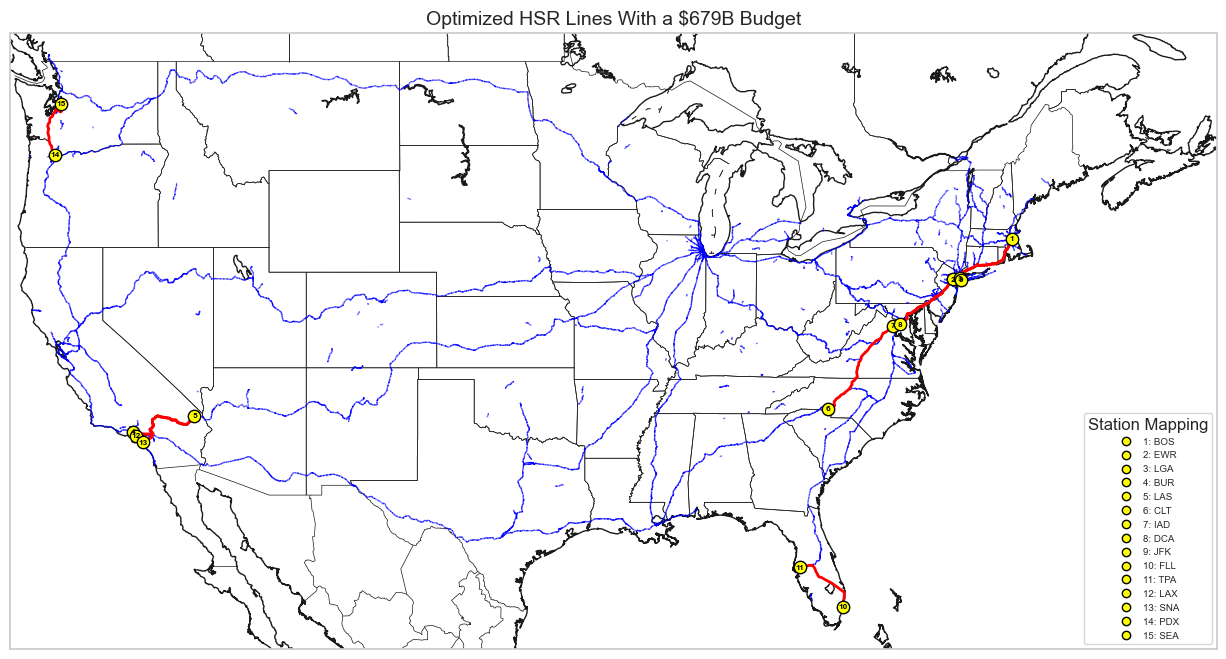

In [862]:
# **Call the function with the corrected station data**
plot_upgraded_routes(gdf, chosen_gdf, upgraded_df, Budget)

# 10 - Plot Ticket Prices

In [910]:
import matplotlib.pyplot as plt
upgraded_df["rail_price"]=(upgraded_df["optimal_price_rev"] + upgraded_df["optimal_price_fwd"])/2
upgraded_df["plane_price"]=(upgraded_df["MktFare_fwd"] + upgraded_df["MktFare_rev"])/2
upgraded_df["plane_time"]=(upgraded_df["flight_time_fwd"] + upgraded_df["flight_time_rev"])/2
upgraded_df["upgraded_rail_time"]=(upgraded_df["upgraded_rail_time_fwd"] + upgraded_df["upgraded_rail_time_rev"])/2
import matplotlib.pyplot as plt

# Extract relevant data
rail_prices = upgraded_df["rail_price"]
plane_prices = upgraded_df["plane_price"]
rail_times = upgraded_df["upgraded_rail_time"]  # In hours
plane_times = upgraded_df["plane_time"]  # In hours

# Debug: Check first few values
print(upgraded_df[["rail_price", "plane_price", "upgraded_rail_time", "plane_time"]].head())



     rail_price  plane_price  upgraded_rail_time  plane_time
275  171.835209   202.333333           93.091075  122.027532
289  123.538793   144.416667           88.998040  120.435951
382  122.930953   154.675000          105.257608  124.287782
564  259.369911   313.627500          126.079347  134.148485
741  329.831809   374.000000           93.099418  123.264563


In [911]:
Budget * 1e-6

300000.0

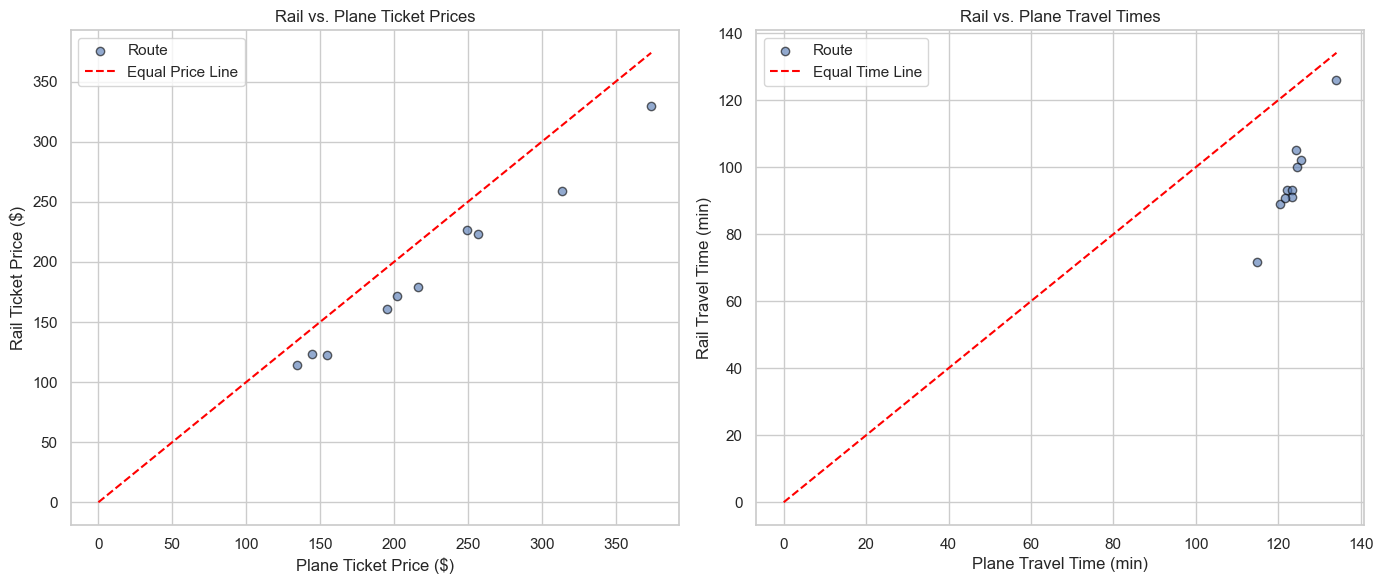

In [912]:
# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# **Plot 1: Rail vs. Plane Ticket Prices**
axes[0].scatter(plane_prices, rail_prices, alpha=0.6, edgecolors="black", label="Route")
max_price = max(max(rail_prices), max(plane_prices))
axes[0].plot([0, max_price], [0, max_price], linestyle="dashed", color="red", label="Equal Price Line")
axes[0].set_xlabel("Plane Ticket Price ($)")
axes[0].set_ylabel("Rail Ticket Price ($)")
axes[0].set_title("Rail vs. Plane Ticket Prices")
axes[0].legend()

# **Plot 2: Rail vs. Plane Travel Times**
axes[1].scatter(plane_times, rail_times, alpha=0.6, edgecolors="black", label="Route")
max_time = max(max(rail_times), max(plane_times))
axes[1].plot([0, max_time], [0, max_time], linestyle="dashed", color="red", label="Equal Time Line")
axes[1].set_xlabel("Plane Travel Time (min)")
axes[1].set_ylabel("Rail Travel Time (min)")
axes[1].set_title("Rail vs. Plane Travel Times")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.savefig(f"prices_and_times_${(Budget * 1e-9).__round__()}B_budget.png", dpi=300, bbox_inches="tight")  # Save as high-quality PNG
plt.show()

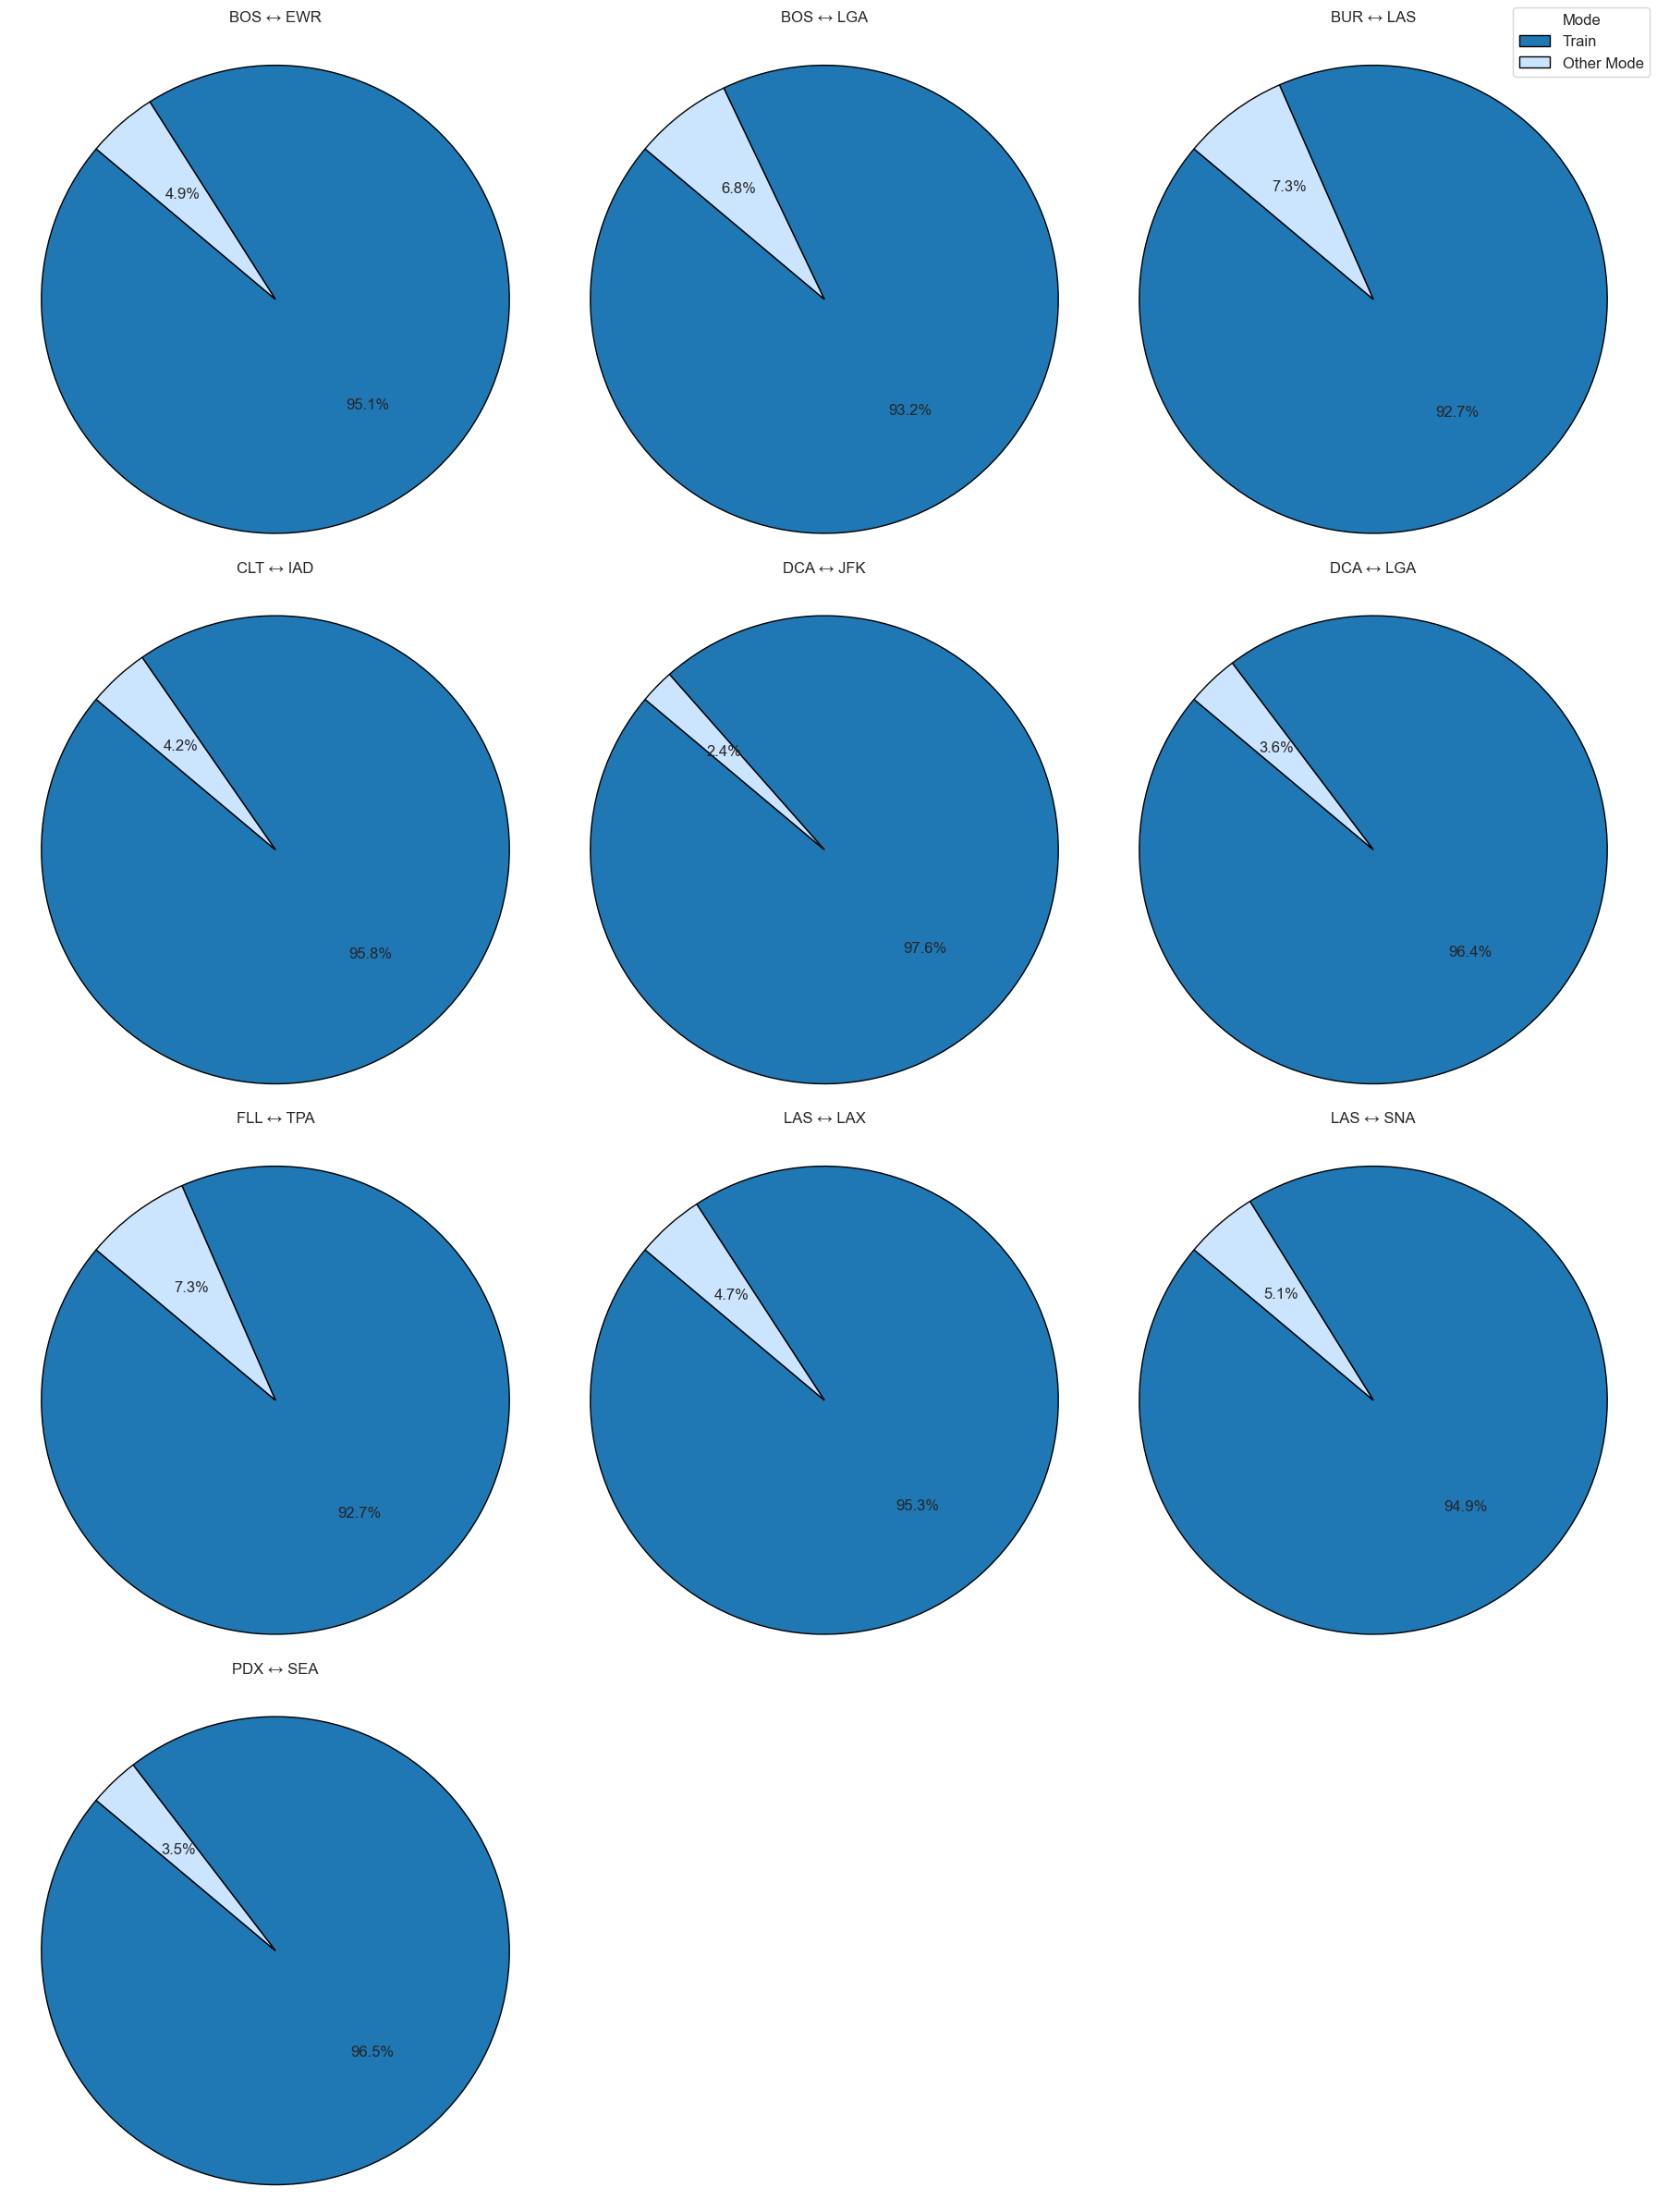

In [913]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Set seaborn style for aesthetics
sns.set_theme(style="whitegrid")

# Compute train demand for each upgraded route using your logit function.
upgraded_df["train_demand"] = upgraded_df.apply(
    lambda row: logit_demand(
        price_train=row["rail_price"],
        price_plane=row["plane_price"],
        base_demand=row["proxy_flight_demand_fwd"],  # Base demand taken from flight demand
        time_savings=row["upgraded_rail_time"] - row["plane_time"]  # Time savings = plane time - train time
    ),
    axis=1
)

# Define grid layout for pie charts
n_routes = len(upgraded_df)
n_cols = 3  # Adjust number of columns as needed
n_rows = int(np.ceil(n_routes / n_cols))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()  # Flatten to index subplots easily

# Define custom colors:
# Dark blue for Train; very light pastel blue for Other Mode.
dark_blue = "#1f77b4"
light_pastel_blue = "#cce5ff"
colors = [dark_blue, light_pastel_blue]

# Loop over each route and plot the pie chart without internal titles.
for i, (idx, row) in enumerate(upgraded_df.iterrows()):
    ax = axes[i]
    
    # Calculate mode demand splits.
    train_demand = row["train_demand"]
    flight_demand = row["proxy_flight_demand_fwd"] - train_demand
    sizes = [train_demand, flight_demand]
    
    # Plot pie chart (without internal labels).
    ax.pie(sizes, autopct='%1.1f%%', colors=colors, startangle=140,
           wedgeprops={'edgecolor': 'black'})
    ax.axis('equal')  # Ensure the pie is drawn as a circle.
    
    # Annotate above the chart with a bi-directional arrow.
    route_text = f"{row['Origin_fwd']} \u2194 {row['Dest_fwd']}"
    ax.annotate(route_text, xy=(0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=12)

# Hide any unused subplots in the grid.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Create legend handles for the two modes.
legend_handles = [
    Patch(facecolor=dark_blue, edgecolor='black', label='Train'),
    Patch(facecolor=light_pastel_blue, edgecolor='black', label='Other Mode')
]

# Add a legend to the figure (placed in the upper right).
fig.legend(handles=legend_handles, loc='upper right', fontsize=12, title="Mode")

plt.tight_layout()
plt.savefig(f"modesplit${(Budget * 1e-9).__round__()}B_budget.png", dpi=300, bbox_inches="tight")  # Save as high-quality PNG

plt.show()

In [746]:
# Logit example
train_tickets = np.linspace(300,700)
plane_tickets = 500
train_time = 135
plane_time = 120
demand = 10000

demands = [logit_demand(
        price_train=x,
        price_plane=plane_tickets,
        base_demand=demand,  # Base demand taken from flight demand
        time_savings=train_time-plane_time  # Time savings = plane time - train time
    ) for x in train_tickets]

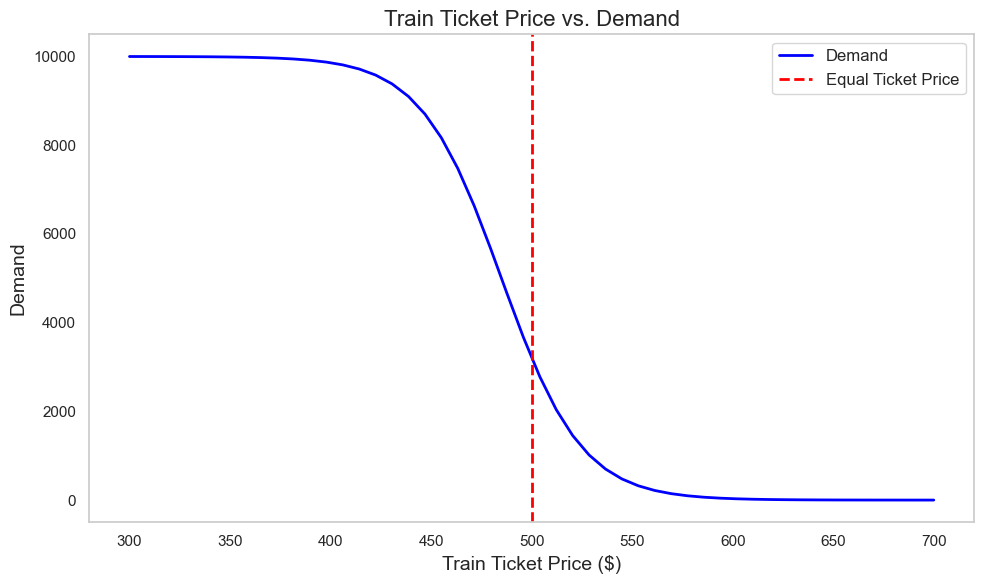

In [712]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_tickets, demands, color='blue', linewidth=2, label='Demand')
plt.axvline(500, color='red', linestyle='--', linewidth=2, label='Equal Ticket Price')
plt.xlabel('Train Ticket Price ($)', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.title('Train Ticket Price vs. Demand', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)  # Hide gridlines
plt.tight_layout()
plt.savefig(f"LOGIT_Demo.png", dpi=300, bbox_inches="tight")  # Save as high-quality PNG
plt.show()